In [57]:
import numpy as np 
import pandas as pd

stock_symbol = 'PFE' # MRK, PFE, XIC.TO, JNJ, ^GSPTSE

# ideally we want to automate this process for any index/stock, but for now we just use
#    a manually downloaded file from yahoo finance
raw_data = pd.read_csv('{}.csv'.format(stock_symbol)) # ^GSPTSE.csv, MRK.csv, PFE.csv
raw_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1972-06-01,0.000000,0.815346,0.802993,0.815346,0.171185,2458771
1,1972-06-02,0.815346,0.817817,0.802993,0.805463,0.169110,1613885
2,1972-06-05,0.805463,0.807934,0.798051,0.802993,0.168591,2585251
3,1972-06-06,0.802993,0.825229,0.800522,0.820288,0.172222,2347469
4,1972-06-07,0.820288,0.820288,0.807934,0.820288,0.172222,1032077


In [58]:
date_close = raw_data.loc[:, ('Date', 'Adj Close')]
date_close

,Date,Adj Close
0,1972-06-01,0.171185
1,1972-06-02,0.169110
2,1972-06-05,0.168591
3,1972-06-06,0.172222
4,1972-06-07,0.172222
...,...,...
12939,2023-09-25,32.980000
12940,2023-09-26,32.400002
12941,2023-09-27,32.099998
12942,2023-09-28,32.090000


In [59]:
cleaned = date_close.dropna() # removes any existing null values
cleaned

,Date,Adj Close
0,1972-06-01,0.171185
1,1972-06-02,0.169110
2,1972-06-05,0.168591
3,1972-06-06,0.172222
4,1972-06-07,0.172222
...,...,...
12939,2023-09-25,32.980000
12940,2023-09-26,32.400002
12941,2023-09-27,32.099998
12942,2023-09-28,32.090000


We want a histogram of the % change in price, in buckets/bins.
First we need an array of all the % changes.

In [60]:
prices = cleaned.loc[:, 'Adj Close']
prices_array = prices.to_numpy()
row_count = len(prices_array) # range of our for loop

# ((prices_array[1] - prices_array[0]) / prices_array[0]) * 100

delta = []
for i in range(row_count - 1):
    percent_change = ((prices_array[i + 1] - prices_array[i]) / prices_array[i]) * 100
    delta.append(percent_change)

print(min(delta))
print(max(delta))

sorted_deltas = np.sort(delta)
print(sorted_deltas)

-17.29960442452824
10.855178937990244
[-17.29960442 -11.76470588 -11.14560343 ...  10.17173557  10.24393552
  10.85517894]


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 4.000e+00, 0.000e+00, 5.000e+00, 1.100e+01, 2.100e+01,
        4.700e+01, 8.500e+01, 2.700e+02, 6.520e+02, 1.859e+03, 2.916e+03,
        3.874e+03, 1.894e+03, 6.820e+02, 3.640e+02, 1.450e+02, 5.400e+01,
        3.200e+01, 1.300e+01, 7.000e+00, 2.000e+00, 3.000e+00]),
 array([-18., -17., -16., -15., -14., -13., -12., -11., -10.,  -9.,  -8.,
         -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,
          4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.]),
 <BarContainer object of 29 artists>)

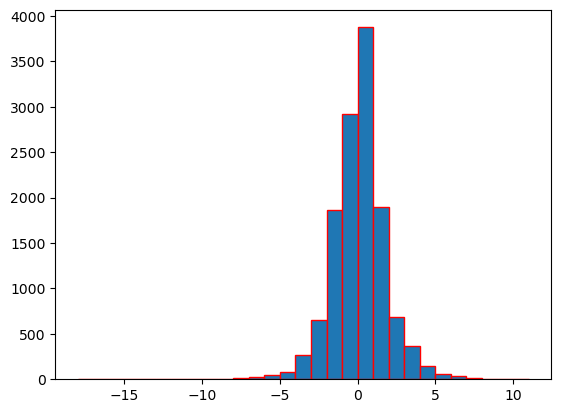

In [61]:
import matplotlib.pyplot as plt
import math

bins_min = math.floor(min(delta))
bins_max = math.ceil(max(delta))
bins_test = np.arange(bins_min, bins_max + 1) # (min - 1, max + 1)

plt.hist(sorted_deltas, edgecolor = 'red', bins = bins_test)

next steps:

- append delta array as column to 'cleaned' data frame, so we can correspond dates to major price changes
- find mean and standard deviation
- calculate z score for 95% of all values
- probability distribution of the deltas

In [62]:
delta_copy = delta.copy()
delta_copy.insert(0, None) # needed since there isnt a price change at the start
cleaned_copy = cleaned.copy()
cleaned_copy['Delta'] = delta_copy
cleaned_copy

,Date,Adj Close,Delta
0,1972-06-01,0.171185,NaN
1,1972-06-02,0.169110,-1.212139
2,1972-06-05,0.168591,-0.306901
3,1972-06-06,0.172222,2.153733
4,1972-06-07,0.172222,0.000000
...,...,...,...
12939,2023-09-25,32.980000,0.887125
12940,2023-09-26,32.400002,-1.758636
12941,2023-09-27,32.099998,-0.925938
12942,2023-09-28,32.090000,-0.031146


In [63]:
# mean and variance, Z = ± 1.96?

delta_mean = sum(delta) / len(delta)
delta_variance = np.var(delta)
delta_sigma = math.sqrt(delta_variance)

print(delta_mean)
print(delta_variance)
print(delta_sigma)

0.05570071777950414
2.9997706665429376
1.7319846034370334


In [64]:
# Z = (x - u) / sigma
# x = u + (Z * sigma) 
# Z = ± 1.96

tails = np.array([-1.96, 1.96]) 
a = 14
normalized_bounds = delta_mean + tails.dot(delta_sigma)
print(normalized_bounds)

[-3.3389891   3.45039054]


find the % of data that is beyond these bounds

In [65]:
# sorted_deltas vs normalized_bounds

bound_counts = {
    'lower' : 0,
    'upper' : 0
}

for i in sorted_deltas:
    if i < normalized_bounds[0]:
        bound_counts['lower'] += 1
    elif i > normalized_bounds[1]:
        bound_counts['upper'] += 1
    else: 
        continue

print(bound_counts)

observation_count = len(sorted_deltas)

bound_percentages = {
    'lower' : 100 * (bound_counts['lower'] / observation_count),
    'upper' : 100 * (bound_counts['upper'] / observation_count)
}

print(bound_percentages)

{'lower': 325, 'upper': 417}
{'lower': 2.511009812253728, 'upper': 3.221818743722475}


In [66]:
delta_extremes = cleaned_copy.copy()
print(normalized_bounds)

extremes = [] #list of booleans to be appended to delta_extremes

for ind in delta_extremes.index:
    if ind == 0:
        extremes.append(None)
    elif delta_extremes['Delta'][ind] < normalized_bounds[0]:
        extremes.append('Negative Extreme')
    elif delta_extremes['Delta'][ind] > normalized_bounds[1]:
        extremes.append('Positive Extreme')
    else:
        extremes.append('Non-Extreme')

delta_extremes['Extremes'] = extremes
delta_extremes.head()
# we need to iterate over the rows, check delta cell and see if the value is outside of normalized_bounds
#   if so, mark it 1, 0 otherwise

[-3.3389891   3.45039054]


,Date,Adj Close,Delta,Extremes
0,1972-06-01,0.171185,NaN,None
1,1972-06-02,0.169110,-1.212139,Non-Extreme
2,1972-06-05,0.168591,-0.306901,Non-Extreme
3,1972-06-06,0.172222,2.153733,Non-Extreme
4,1972-06-07,0.172222,0.000000,Non-Extreme


In [67]:
# only need to do this step if dividends file exists

try:
    dividends = pd.read_csv('{}_dividends.csv'.format(stock_symbol))
    dividends_clean = dividends.dropna()
    # print(len(dividends_clean))

    cleaned_copy2 = cleaned.copy()
    # cleaned_copy2.head()

    dividend_frame = pd.merge(dividends_clean, cleaned_copy2, how = "inner")
    # dividend_frame.head()
    # merge dividends_clean with, cleaned dataframe
    print(dividend_frame)
except:
    print('This stock/index does not pay dividends.')


           Date  Dividends  Adj Close
0    1972-11-28   0.004151   0.181551
1    1973-02-28   0.003163   0.178028
2    1973-05-30   0.003163   0.178169
3    1973-08-28   0.003163   0.190970
4    1973-11-27   0.004349   0.187674
..          ...        ...        ...
199  2022-07-28   0.400000  48.754871
200  2022-11-03   0.400000  45.149338
201  2023-01-26   0.410000  43.293957
202  2023-05-11   0.410000  37.165928
203  2023-07-27   0.410000  36.200001

[204 rows x 3 columns]


In [68]:
try: 
    dividends = pd.read_csv('{}_dividends.csv'.format(stock_symbol))

except:
    print('This stock/index does not pay dividends.')

else: 
    dividend_array = dividend_frame.loc[:, 'Dividends'].to_numpy()
    prices_array2 = dividend_frame.loc[:, 'Adj Close'].to_numpy()
    row_count2 = len(prices_array2)

    dividend_deltas = []
    for j in range(row_count2 - 1):
        dividend_delta = ((dividend_array[j + 1] + prices_array2[j + 1] - prices_array2[j])
                        / prices_array2[j]) * 100
        dividend_deltas.append(dividend_delta)

    dividend_deltas_copy = dividend_deltas.copy()
    dividend_deltas_copy.insert(0, None)
    dividend_returns = dividend_frame.copy()
    dividend_returns['Total Return Delta'] = dividend_deltas_copy
    # print(dividend_returns)

    dividend_delta_mean = sum(dividend_deltas) / len(dividend_deltas)
    print(dividend_delta_mean)
    dividend_delta_var = np.var(dividend_deltas)
    print(dividend_delta_var)
    dividend_delta_sigma = math.sqrt(dividend_delta_var)
    print(dividend_delta_sigma)
    print(tails)
    dividend_bounds = dividend_delta_mean + tails.dot(dividend_delta_sigma)
    print(dividend_bounds)

    dividend_extremes = dividend_returns.copy()
    extremes_sorted = []

    for j in dividend_extremes.index:  
        if j == 0:
              extremes_sorted.append(None)
        elif dividend_extremes['Total Return Delta'][j] < dividend_bounds[0]:
              extremes_sorted.append('Negative Extreme')
        elif dividend_extremes['Total Return Delta'][j] > dividend_bounds[1]:
              extremes_sorted.append('Positive Extreme')
        else:
              extremes_sorted.append('Non-Extreme')

    dividend_extremes['Extremes'] = extremes_sorted
    print(dividend_extremes)


5.095868051206058
121.78085033464706
11.035436118914696
[-1.96  1.96]
[-16.53358674  26.72532284]
           Date  Dividends  Adj Close  Total Return Delta     Extremes
0    1972-11-28   0.004151   0.181551                 NaN         None
1    1973-02-28   0.003163   0.178028           -0.198291  Non-Extreme
2    1973-05-30   0.003163   0.178169            1.855888  Non-Extreme
3    1973-08-28   0.003163   0.190970            8.960032  Non-Extreme
4    1973-11-27   0.004349   0.187674            0.551396  Non-Extreme
..          ...        ...        ...                 ...          ...
199  2022-07-28   0.400000  48.754871            2.268130  Non-Extreme
200  2022-11-03   0.400000  45.149338           -6.574795  Non-Extreme
201  2023-01-26   0.410000  43.293957           -3.201334  Non-Extreme
202  2023-05-11   0.410000  37.165928          -13.207453  Non-Extreme
203  2023-07-27   0.410000  36.200001           -1.495797  Non-Extreme

[204 rows x 5 columns]


5.095868051206059


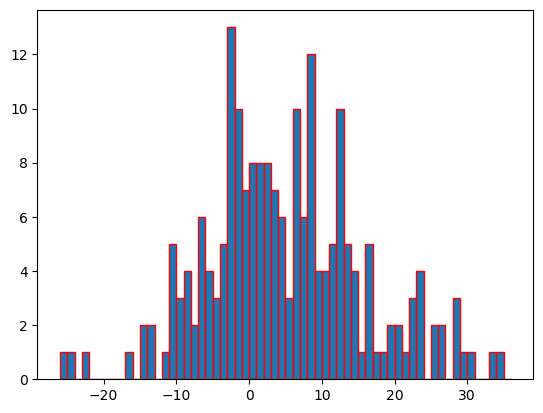

In [69]:
try: 
    dividends = pd.read_csv('{}_dividends.csv'.format(stock_symbol))

except:
    print('This stock/index does not pay dividends.')

else: 
    dividend_min = math.floor(min(dividend_deltas))
    dividend_max = math.floor(max(dividend_deltas))
    dividend_bins = np.arange(dividend_min, dividend_max + 1)
    plt.hist(dividend_deltas, edgecolor = 'red', bins = dividend_bins)

    import statistics
    print(statistics.mean(dividend_deltas))

In [70]:
dividend_extremes

,Date,Dividends,Adj Close,Total Return Delta,Extremes
0,1972-11-28,0.004151,0.181551,NaN,None
1,1973-02-28,0.003163,0.178028,-0.198291,Non-Extreme
2,1973-05-30,0.003163,0.178169,1.855888,Non-Extreme
3,1973-08-28,0.003163,0.190970,8.960032,Non-Extreme
4,1973-11-27,0.004349,0.187674,0.551396,Non-Extreme
...,...,...,...,...,...
199,2022-07-28,0.400000,48.754871,2.268130,Non-Extreme
200,2022-11-03,0.400000,45.149338,-6.574795,Non-Extreme
201,2023-01-26,0.410000,43.293957,-3.201334,Non-Extreme
202,2023-05-11,0.410000,37.165928,-13.207453,Non-Extreme


In [71]:
delta_extremes

,Date,Adj Close,Delta,Extremes
0,1972-06-01,0.171185,NaN,None
1,1972-06-02,0.169110,-1.212139,Non-Extreme
2,1972-06-05,0.168591,-0.306901,Non-Extreme
3,1972-06-06,0.172222,2.153733,Non-Extreme
4,1972-06-07,0.172222,0.000000,Non-Extreme
...,...,...,...,...
12939,2023-09-25,32.980000,0.887125,Non-Extreme
12940,2023-09-26,32.400002,-1.758636,Non-Extreme
12941,2023-09-27,32.099998,-0.925938,Non-Extreme
12942,2023-09-28,32.090000,-0.031146,Non-Extreme


In [72]:
import os

os.makedirs('/home/gabe-fabia/Documents/data-science/dataframes', exist_ok=True)
delta_extremes.to_csv('/home/gabe-fabia/Documents/data-science/dataframes/{}_delta_extremes.csv'.format(stock_symbol))
try: 
    dividends = pd.read_csv('{}_dividends.csv'.format(stock_symbol))

except:
    print('This stock/index does not pay dividends.')

else: 
    dividend_extremes.to_csv('/home/gabe-fabia/Documents/data-science/dataframes/{}_dividend_extremes.csv'.format(stock_symbol))